# Blood Group Detection from Fingerprint using ResNet50

#### Import the required libraries

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

In [2]:
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import zipfile
import warnings
warnings.filterwarnings('ignore')

2025-04-03 14:56:47.368438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743672408.062507   93653 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743672408.247952   93653 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743672410.072015   93653 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743672410.072100   93653 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743672410.072103   93653 computation_placer.cc:177] computation placer alr

#### Data preprocessing

In [3]:
file_path = '/home/rgukt/Downloads/PROJECT/dataset_blood_group'

In [4]:
data = pd.DataFrame({
    'Filepath': glob.glob(file_path + "/*/*"),
    'Label': [os.path.basename(os.path.dirname(fp)) for fp in glob.glob(file_path + "/*/*")]
})

#### Splitting the dataset into train and test sets

In [5]:
train, test = train_test_split(data, test_size=0.20, random_state=42, stratify=data["Label"])

In [6]:
print(f"Total dataset size: {len(data)} samples")
print(f"Training set size: {len(train)} samples ({len(train)/len(data)*100:.1f}%)")
print(f"Test/Validation set size: {len(test)} samples ({len(test)/len(data)*100:.1f}%)")

Total dataset size: 6000 samples
Training set size: 4800 samples (80.0%)
Test/Validation set size: 1200 samples (20.0%)


#### Image data augmentation

In [5]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4800 validated image filenames belonging to 8 classes.
Found 1200 validated image filenames belonging to 8 classes.


In [6]:
print(train_gen.class_indices)

{'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7}


#### Model architecture

In [6]:
pretrained_model = ResNet50(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

2025-03-25 16:49:43.872688: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,867,528 (91.05 MB)

 Trainable params: 279,816 (1.07 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

#### Model training

In [8]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20
)

Epoch 1/20


2025-03-25 16:50:05.281511: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-03-25 16:50:06.306642: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 138444800 exceeds 10% of free system memory.
2025-03-25 16:50:06.462877: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-03-25 16:50:06.921388: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2025-03-25 16:50:07.524415: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


150/150 ━━━━━━━━━━━━━━━━━━━━ 1322s 9s/step - accuracy: 0.4114 - loss: 1.5329 - val_accuracy: 0.6217 - val_loss: 0.9383
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1219s 8s/step - accuracy: 0.6703 - loss: 0.8404 - val_accuracy: 0.6692 - val_loss: 0.8497
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1371s 9s/step - accuracy: 0.7467 - loss: 0.6806 - val_accuracy: 0.7317 - val_loss: 0.6576
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1372s 9s/step - accuracy: 0.7989 - loss: 0.5599 - val_accuracy: 0.7517 - val_loss: 0.6361
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1205s 8s/step - accuracy: 0.8166 - loss: 0.4728 - val_accuracy: 0.7742 - val_loss: 0.5691
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1211s 8s/step - accuracy: 0.8255 - loss: 0.4485 - val_accuracy: 0.7692 - val_loss: 0.5716
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1204s 8s/step - accuracy: 0.8568 - loss: 0.3659 - val_accuracy: 0.7675 - val_loss: 0.5766
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 1368s 9s/step - accuracy: 0.8638 - loss: 0.3565 - val_accurac

#### Saving the model

In [9]:
model.save("resnet50.keras")
print("Model Saved Successfully")

Model Saved Successfully


In [10]:
model.save("model_best.h5")
print("MODEL SAVED SUCCESSFULLY")

MODEL SAVED SUCCESSFULLY


#### Model evaluation

In [11]:
name_class = sorted(os.listdir(file_path))
pred = model.predict(valid_gen)
pred_labels = np.argmax(pred, axis=1)
true_labels = valid_gen.classes

print(classification_report(true_labels, pred_labels, target_names=name_class))

38/38 ━━━━━━━━━━━━━━━━━━━━ 277s 7s/step 
              precision    recall  f1-score   support

          A+       0.92      0.82      0.87       113
          A-       0.78      0.71      0.74       202
         AB+       0.85      0.77      0.81       142
         AB-       0.79      0.76      0.77       152
          B+       0.72      0.91      0.81       130
          B-       0.84      0.91      0.87       148
          O+       0.71      0.84      0.77       171
          O-       0.81      0.66      0.73       142

    accuracy                           0.79      1200
   macro avg       0.80      0.80      0.80      1200
weighted avg       0.80      0.79      0.79      1200



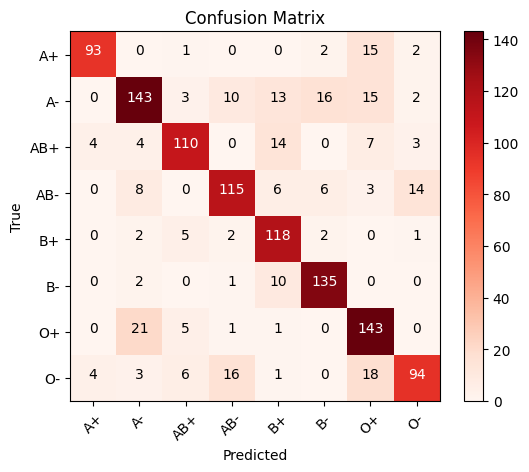

In [12]:
cm = confusion_matrix(true_labels, pred_labels)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(name_class))
plt.xticks(tick_marks, name_class, rotation=45)
plt.yticks(tick_marks, name_class)

for i in range(len(name_class)):
    for j in range(len(name_class)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Visualizing accuracy and loss over epochs

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

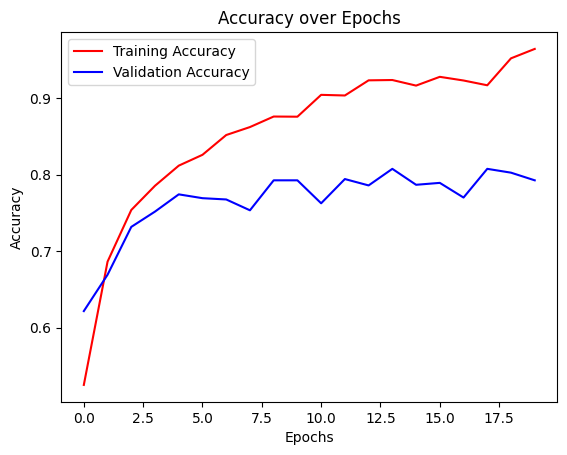

In [14]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

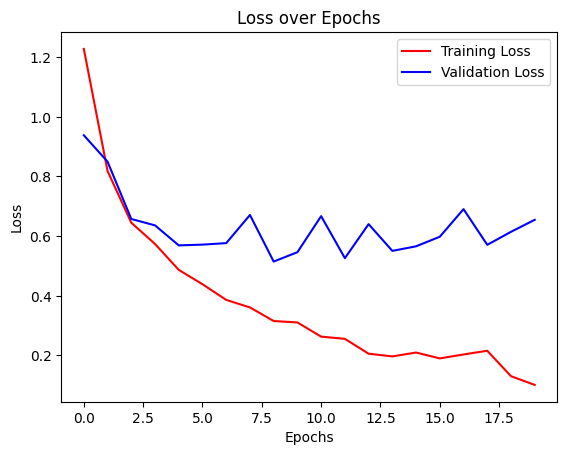

In [15]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### Model prediction

In [16]:
class_names = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

def predict_blood_group(image_path, model, class_names):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    confidence_score = np.max(predictions) * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score:.2f}%", fontsize=14, color='black')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


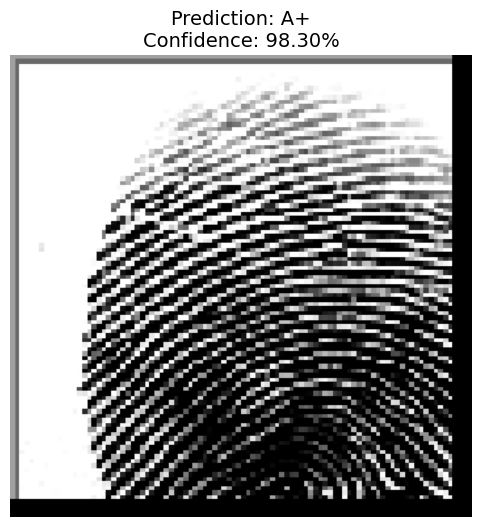

In [17]:
image_path = '/home/rgukt/Downloads/PROJECT/dataset_blood_group/A+/cluster_0_1001.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


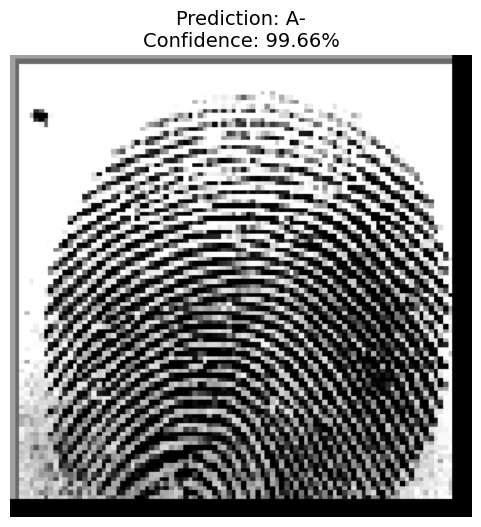

In [18]:
image_path = '/home/rgukt/Downloads/PROJECT/dataset_blood_group/A-/cluster_1_1007.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


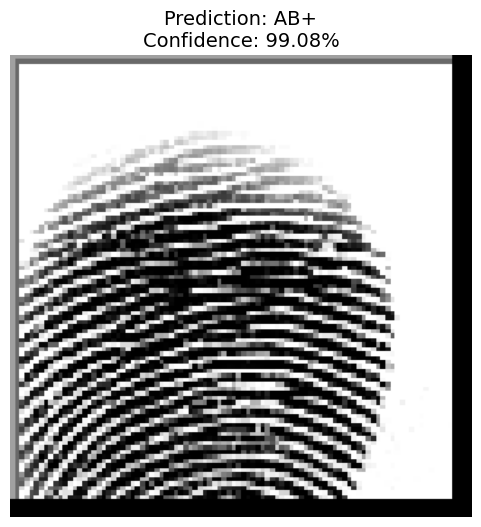

In [19]:
image_path = '/home/rgukt/Downloads/PROJECT/dataset_blood_group/AB+/cluster_4_100.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


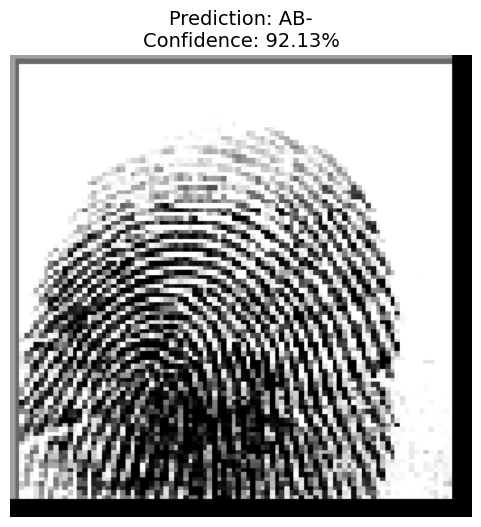

In [20]:
image_path = '/home/rgukt/Downloads/PROJECT/dataset_blood_group/AB-/cluster_5_1052.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step


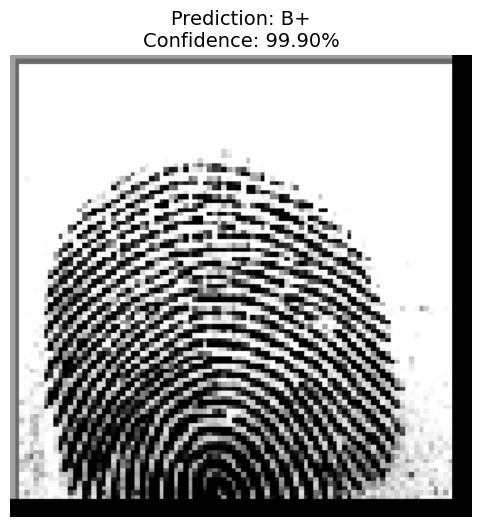

In [21]:
image_path = '/home/rgukt/Downloads/PROJECT/dataset_blood_group/B+/cluster_2_1077.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


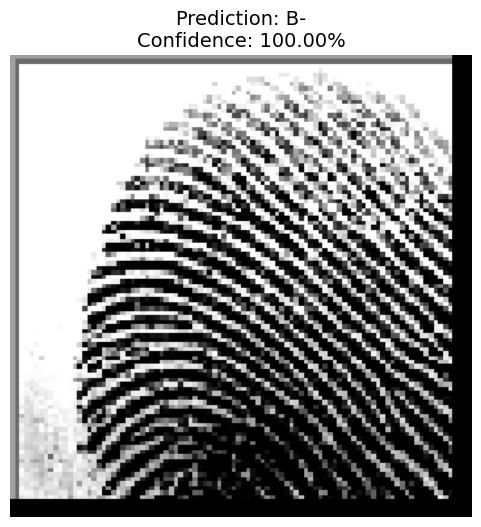

In [22]:
image_path = '/home/rgukt/Downloads/PROJECT/dataset_blood_group/B-/cluster_3_1018.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


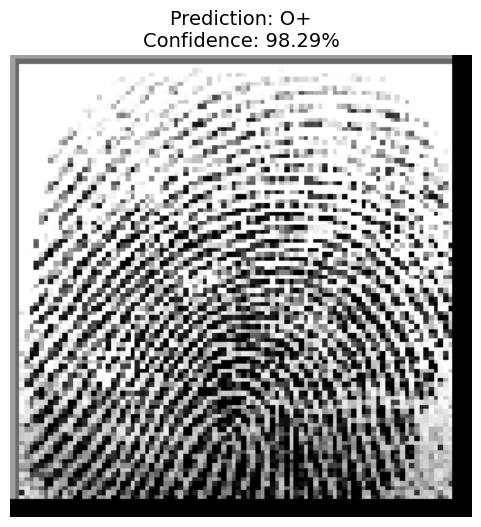

In [23]:
image_path = '/home/rgukt/Downloads/PROJECT/dataset_blood_group/O+/cluster_6_1004.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


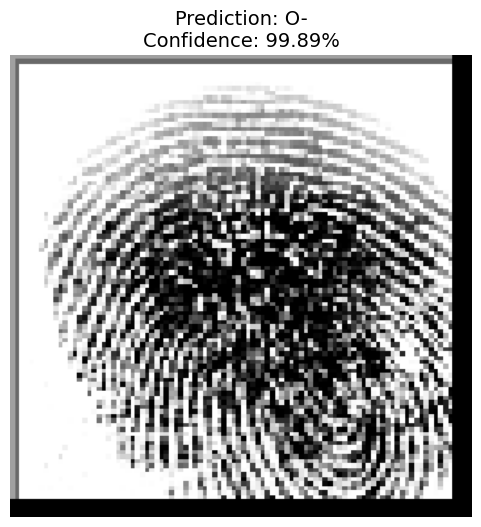

In [25]:
image_path = '/home/rgukt/Downloads/PROJECT/dataset_blood_group/O-/cluster_7_1177.BMP'
predict_blood_group(image_path, model, class_names)

### SUCCESSFULLY  PROJECT  COMPLETED